In [18]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [2]:
review = 'gs://anirocks1/Data/yelp_academic_dataset_review.json'
business = 'gs://anirocks1/Data/yelp_academic_dataset_business.json'
tip = 'gs://anirocks1/YELP_Datasets/yelp_academic_dataset_tip.json'
user = 'gs://anirocks1/YELP_Datasets/yelp_academic_dataset_user.json'
checkin = 'gs://anirocks1/Data/yelp_academic_dataset_checkin.json'

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
# dfr = spark.read.json(review)
dfb = spark.read.json(business)
# dft = spark.read.json(tip)
# dfu = spark.read.json(user)
dfc = spark.read.json(checkin)

22/03/11 21:18:38 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
dfb = dfb.where(dfb.categories.contains('Restaurants'))

In [6]:
df = dfb.select('name', 'business_id').join(dfc, on = 'business_id')

In [7]:
df = df.withColumn('date', F.explode(F.split('date', ',')))
df = df.withColumn('Month', F.month('Date'))
df = df.withColumn('Year', F.year('Date'))
df = df.withColumn("date_only", F.to_date(F.col("Date")))
df = df.withColumn('month_year', F.to_timestamp(F.concat(df.Year, F.lit("/"), df.Month), "yyyy/M"))

In [8]:
df.show(5)

+--------------------+------------+--------------------+-----+----+----------+-------------------+
|         business_id|        name|                date|Month|Year| date_only|         month_year|
+--------------------+------------+--------------------+-----+----+----------+-------------------+
|--164t1nclzzmca7e...|Me So Hungry| 2010-02-26 02:06:53|    2|2010|2010-02-26|2010-02-01 00:00:00|
|--164t1nclzzmca7e...|Me So Hungry| 2010-02-27 08:00:09|    2|2010|2010-02-27|2010-02-01 00:00:00|
|--164t1nclzzmca7e...|Me So Hungry| 2010-03-04 02:00:59|    3|2010|2010-03-04|2010-03-01 00:00:00|
|--164t1nclzzmca7e...|Me So Hungry| 2010-03-11 01:24:46|    3|2010|2010-03-11|2010-03-01 00:00:00|
|--164t1nclzzmca7e...|Me So Hungry| 2010-03-17 02:29:17|    3|2010|2010-03-17|2010-03-01 00:00:00|
+--------------------+------------+--------------------+-----+----+----------+-------------------+
only showing top 5 rows



In [9]:
df.show(5, vertical=True, truncate=False)

-RECORD 0-----------------------------
 business_id | --164t1nclzzmca7eDiJMw 
 name        | Me So Hungry           
 date        | 2010-02-26 02:06:53    
 Month       | 2                      
 Year        | 2010                   
 date_only   | 2010-02-26             
 month_year  | 2010-02-01 00:00:00    
-RECORD 1-----------------------------
 business_id | --164t1nclzzmca7eDiJMw 
 name        | Me So Hungry           
 date        |  2010-02-27 08:00:09   
 Month       | 2                      
 Year        | 2010                   
 date_only   | 2010-02-27             
 month_year  | 2010-02-01 00:00:00    
-RECORD 2-----------------------------
 business_id | --164t1nclzzmca7eDiJMw 
 name        | Me So Hungry           
 date        |  2010-03-04 02:00:59   
 Month       | 3                      
 Year        | 2010                   
 date_only   | 2010-03-04             
 month_year  | 2010-03-01 00:00:00    
-RECORD 3-----------------------------
 business_id | --164t1ncl

In [10]:
top_restaurants = df.groupBy('name').count().orderBy('count', ascending=False)
top_restaurants.show(10)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           Starbucks|58444|
|Chipotle Mexican ...|52320|
|          McDonald's|43616|
|        Panera Bread|38416|
|         Chick-fil-A|37897|
|The Cheesecake Fa...|23850|
|  Whole Foods Market|21917|
|  Buffalo Wild Wings|21822|
|Voodoo Doughnut -...|20291|
|              Subway|19990|
+--------------------+-----+
only showing top 10 rows



In [11]:
top10restaurants = list(top_restaurants.toPandas().name[0:10])
top10restaurants

['Starbucks',
 'Chipotle Mexican Grill',
 "McDonald's",
 'Panera Bread',
 'Chick-fil-A',
 'The Cheesecake Factory',
 'Whole Foods Market',
 'Buffalo Wild Wings',
 'Voodoo Doughnut - Old Town',
 'Subway']

In [12]:
df = df.filter(df.name.isin(top10restaurants))

In [13]:
df.groupBy('name').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|           Starbucks|58444|
|Chipotle Mexican ...|52320|
|          McDonald's|43616|
|        Panera Bread|38416|
|         Chick-fil-A|37897|
|The Cheesecake Fa...|23850|
|  Whole Foods Market|21917|
|  Buffalo Wild Wings|21822|
|Voodoo Doughnut -...|20291|
|              Subway|19990|
+--------------------+-----+



### Monthly

In [14]:
pdf_monthly = df.groupBy('name', 'month_year').count().orderBy(['name', 'count'], ascending=[1,0]).toPandas()
pdf_monthly

,name,month_year,count
0,Buffalo Wild Wings,2012-03-01,330
1,Buffalo Wild Wings,2013-03-01,314
2,Buffalo Wild Wings,2012-09-01,312
3,Buffalo Wild Wings,2012-10-01,309
4,Buffalo Wild Wings,2012-08-01,293
...,...,...,...
1325,Whole Foods Market,2020-06-01,8
1326,Whole Foods Market,2020-07-01,7
1327,Whole Foods Market,2020-11-01,6
1328,Whole Foods Market,2020-04-01,5


In [33]:
import pandas as pd
covid_start = pd.to_datetime('2020-03-13')
covid_start

Timestamp('2020-03-13 00:00:00')

In [16]:
top10restaurants

['Starbucks',
 'Chipotle Mexican Grill',
 "McDonald's",
 'Panera Bread',
 'Chick-fil-A',
 'The Cheesecake Factory',
 'Whole Foods Market',
 'Buffalo Wild Wings',
 'Voodoo Doughnut - Old Town',
 'Subway']

In [20]:
final_restaurants = ['Starbucks', 'Chick-fil-A', 'The Cheesecake Factory', 'Whole Foods Market']

In [39]:
df_new = pdf_monthly[pdf_monthly.name.isin(final_restaurants)]

In [146]:
google = pd.read_csv('multiTimeline.csv', skiprows=1)
google.columns = ['Date', 'Interest']
google.Date = pd.to_datetime(google.Date)

In [153]:
google = google[google.Date >= pd.to_datetime('2010-01-01')]
google.Interest = google.Interest.astype('float') * 10

In [154]:
google.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147 entries, 72 to 218
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      147 non-null    datetime64[ns]
 1   Interest  147 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [155]:
google.head()

,Date,Interest
72,2010-01-01,280.0
73,2010-02-01,290.0
74,2010-03-01,290.0
75,2010-04-01,310.0
76,2010-05-01,340.0


#### Plots including popular restaurants and Yelp Google Search Trends

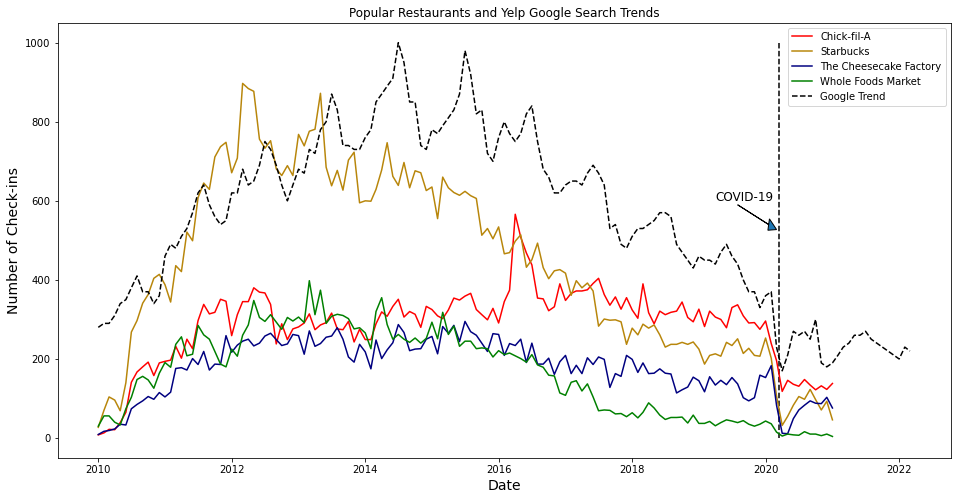

In [185]:
import seaborn as sns
plt.figure(figsize=(16,8))
ax = sns.lineplot(x='month_year', y='count', data=df_new, hue='name', palette=['r', 'darkgoldenrod', 'navy', 'g'])
plt.vlines(covid_start, ymin=0, ymax=1000, color='black', linestyle='--')
plt.xlabel('Date', size=14)
plt.ylabel('Number of Check-ins', size=14)

plt.text(pd.to_datetime('2019-04-01'), 600, 'COVID-19', size=12)
plt.arrow(pd.to_datetime('2019-08-01'), 590, 170, -50, head_width=30)

legend = ax.legend()
plt.legend(fontsize=14)

plt.title('Popular Restaurants and Yelp Google Search Trends')

sns.lineplot(x='Date', y='Interest', data=google, ax=ax, color='black', linestyle='dashed', label='Google Trend')

plt.savefig('covid.png')

#### Plots for top 10 restaurants

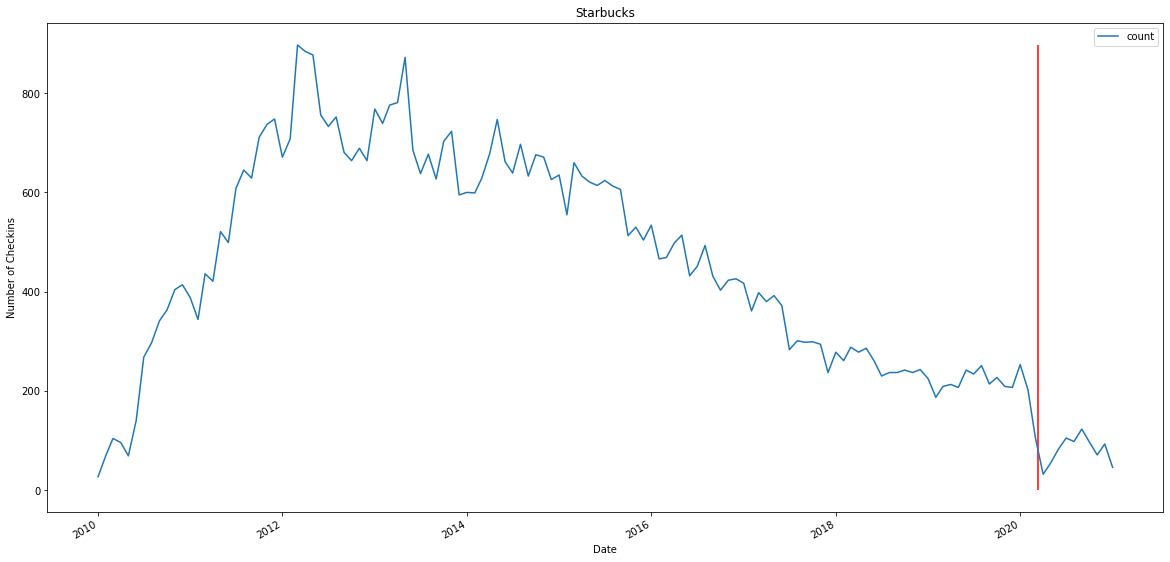

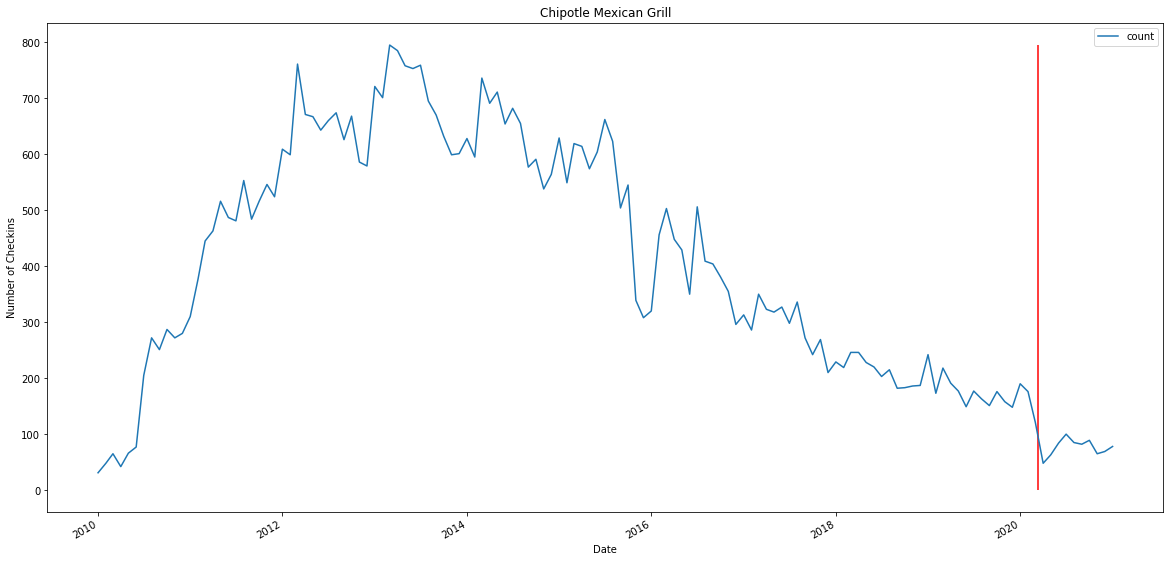

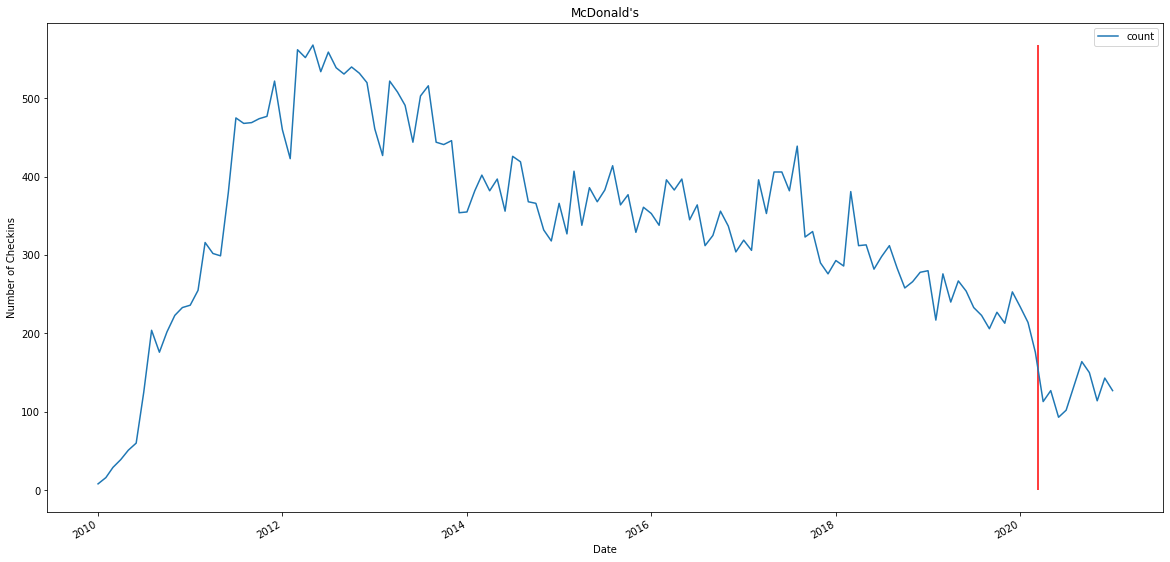

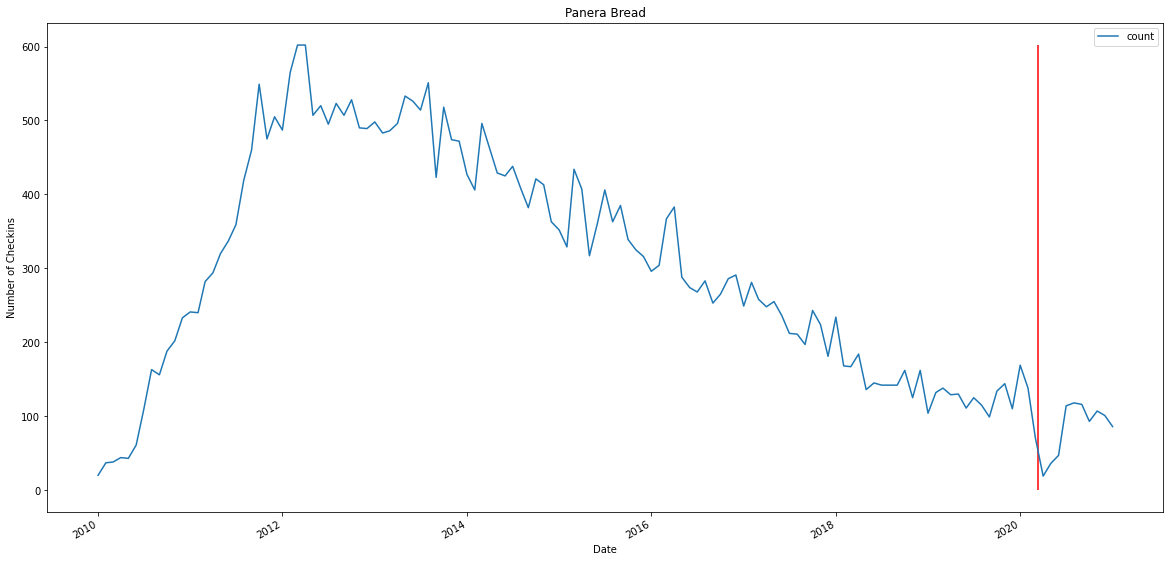

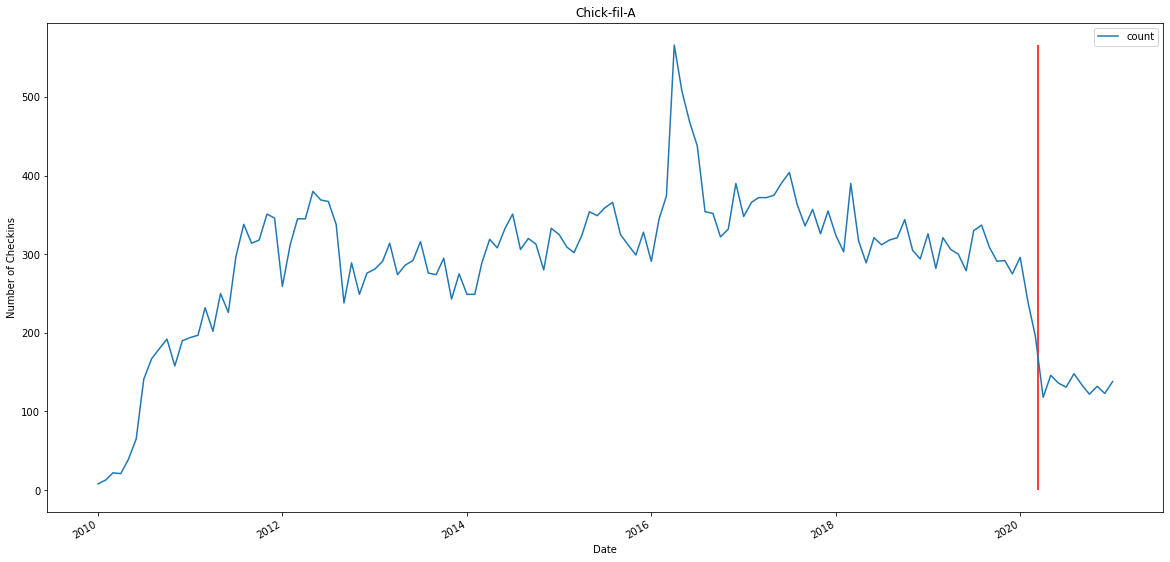

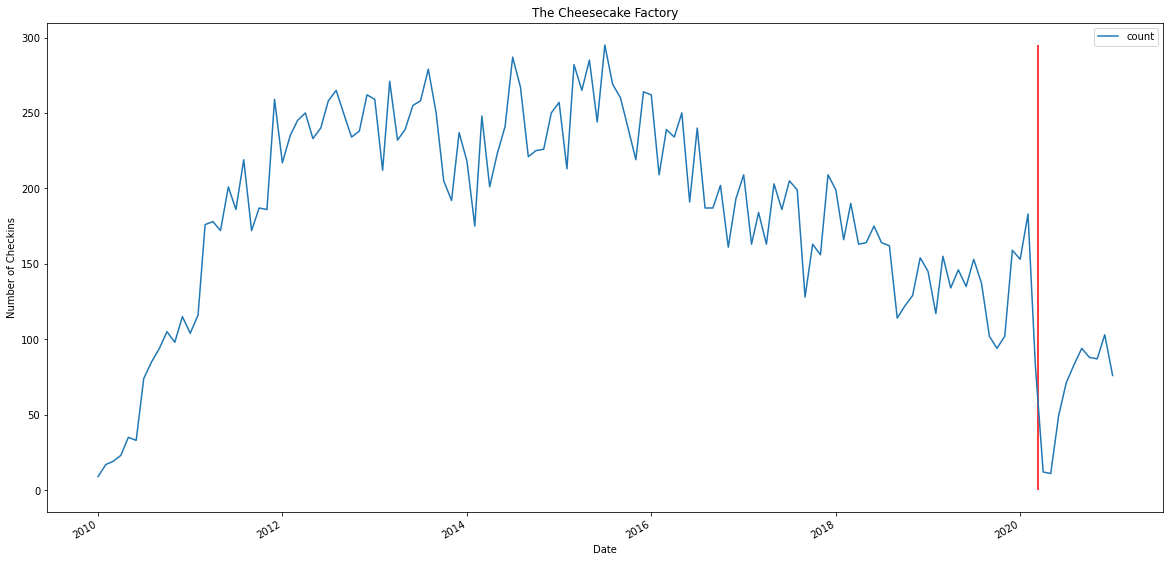

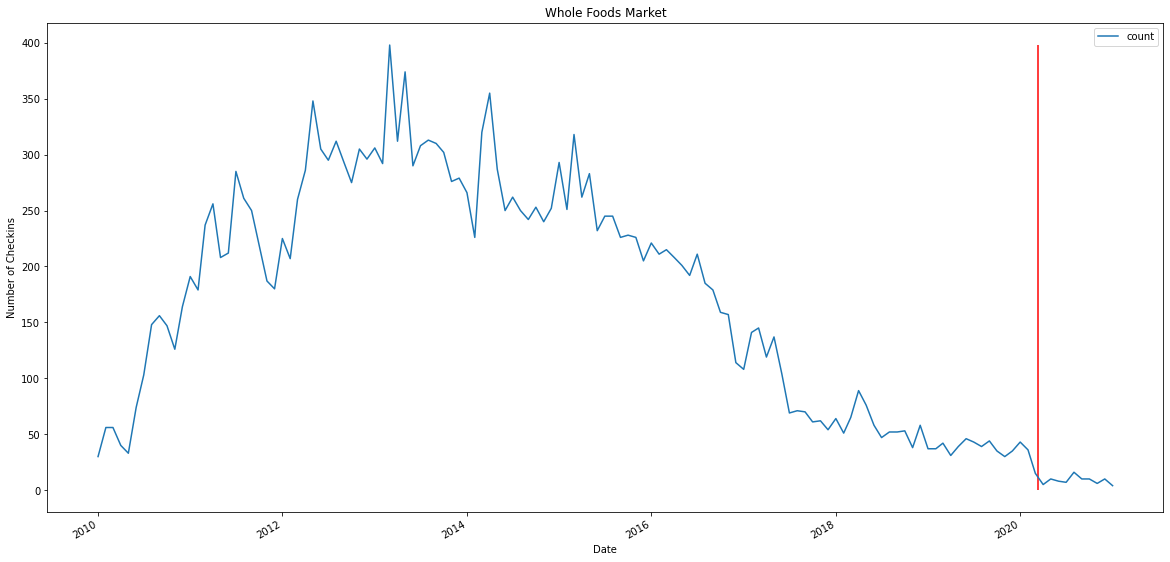

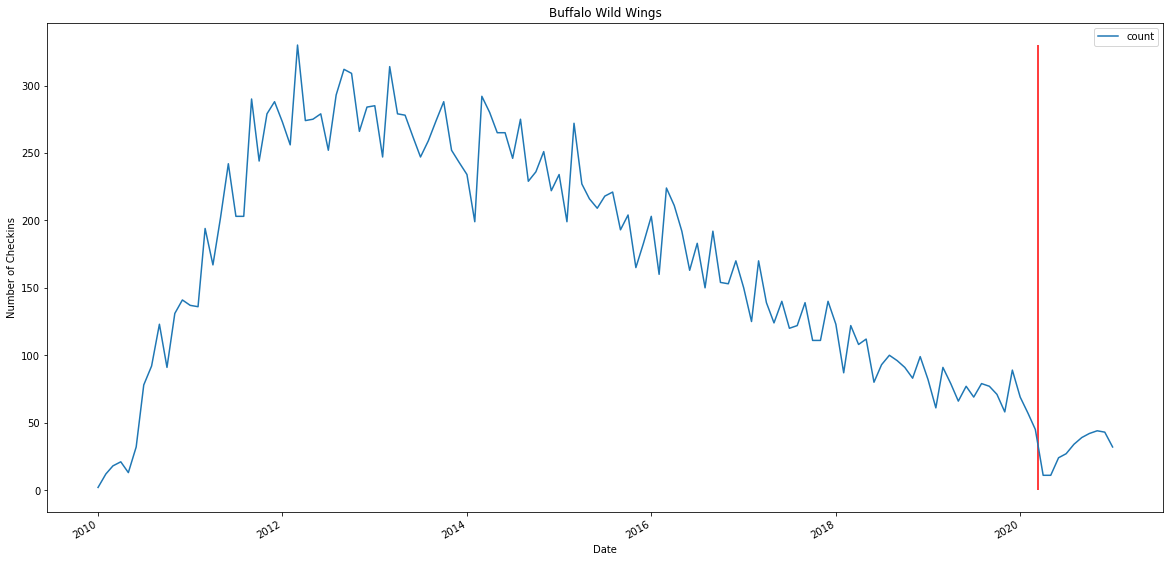

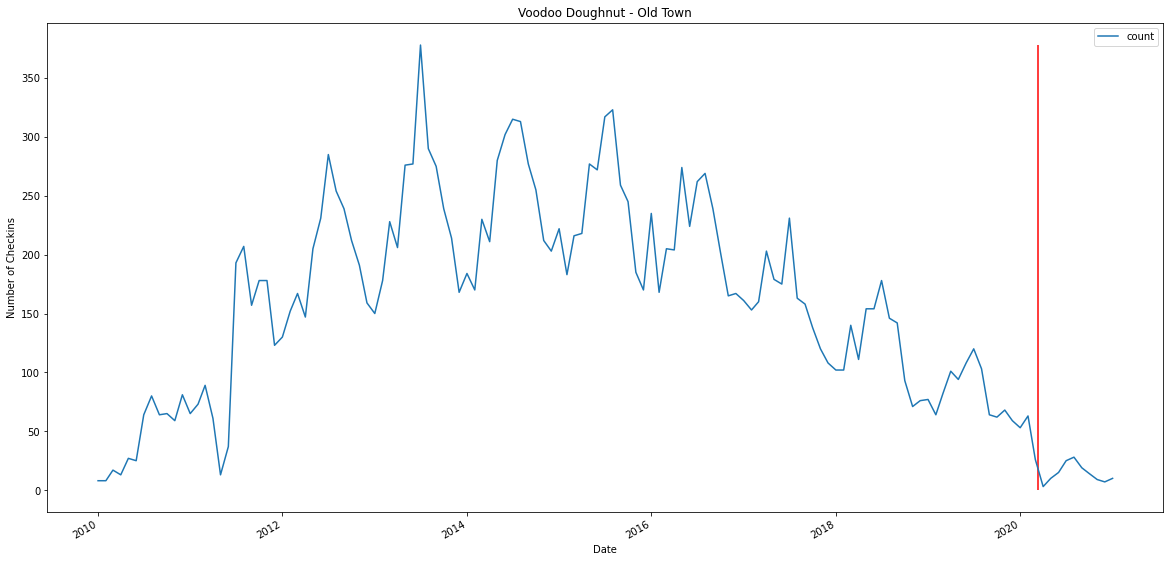

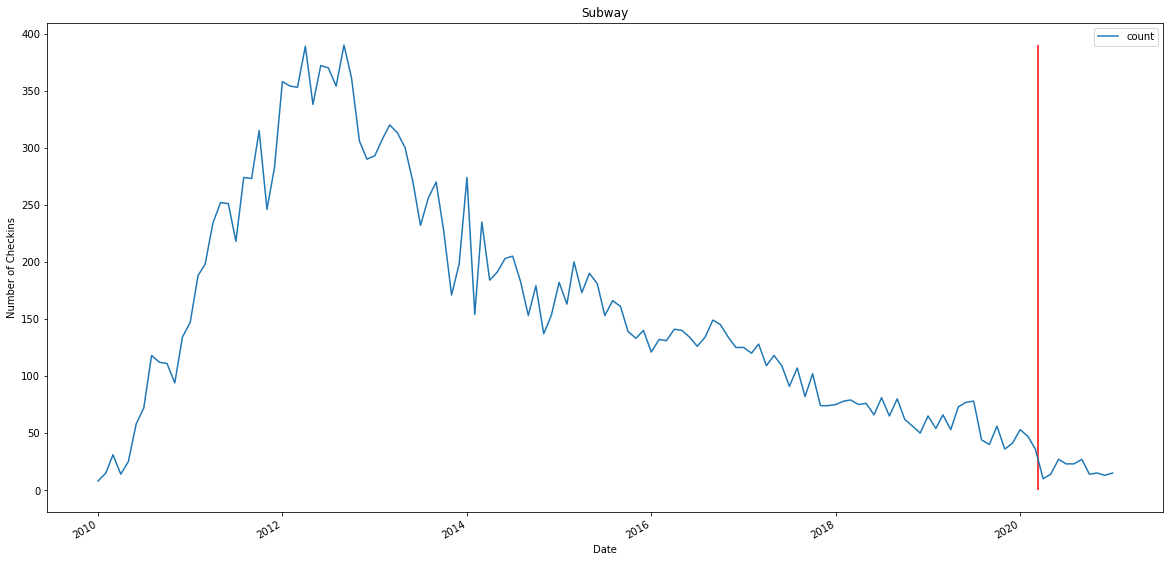

In [19]:
for r in top10restaurants:
    x = pdf_monthly[pdf_monthly['name'] == r]
    x.plot(x='month_year', y='count', figsize=(20,10))
    plt.title(r)
    plt.xlabel('Date')
    plt.ylabel('Number of Checkins')
    plt.vlines(covid_start, ymin=0, ymax= x['count'].max(), color='r')